___
# Welcome to a notebook exploring next sentence prediction (NSP) with Agatha Christie

We are going to use the openly available works of Agatha Christie provided by [*Project Gutenburg*](https://www.gutenberg.org/), who offer a corpus of books free of charge in a variety of formats. We will explore the works of Agatha Christie, in particular the novel *Poirot Investigates*. To get started and work along with the notebook all you have to do is execute the code blocks below, making sure you check that your current working directory is suitable since this is where the files will be stored.

We will stript the preamble from the start and end of the novel automatically using search functions. This removes: contents and prefece etc from the start and any index or legal publishing information from the end - this provides a main body of text which we can further ammend to feed into our model as embeddings

Once a clean main body of text is established we can begin to strip out any unwanted text/punctuation which the model won't be able to interpret properly, the remaining text can be stored as *tokens*. Since we are interested in next sentence prediction (NSP) the tokens can be split into sentences of text, these sentences will be one time step (a word) different each time, which we can then use to train a Long Short Term Memory (LSTM) cell in a Recurrent Neural Network (RNN).  

Follow the code through the notebook and read the prompts are each step for more information.


Enjoy!

___
*Any corrections/comments please email at j.stelling2@ncl.ac.uk*
___

In [5]:
# Install the natural language toolkit for use in Python

# ! pip install nltk 

     |████████████████████████████████| 1.4 MB 12.3 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=1f2311d2507cd80c2668f2b9dfbe8a3adfa5fe82451fdd952a21a1b5f79cecfa
  Stored in directory: /home/azureuser/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk


In [1]:
#Import Tensorflow Keras and Python libraries
import numpy as np
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# Import file processing packages
import os
import shutil
from urllib import request # For dealing with urls

# NLP libraries
import nltk  # natural language toolkit
import re  # regular expressions regex

Using TensorFlow backend.


### Define the novel particulars and the url where it is available. 

In [21]:
title = 'Poirot_Investigates'
author = 'Agatha_Christie'
url = 'https://www.gutenberg.org/files/61262/61262-0.txt'

# Set this path to your working directory
# os.getcwd()
path = './Agatha/'
cwd = os.getcwd()

### Write a function to retrieve the file from url:

In [22]:

# Check if the file is stored locally
filename = path + title
if os.path.isfile(filename) and os.stat(filename).st_size != 0: # If the file is there and it isn't empty 
        print(f'We already have {title} by {author}')
        print('----------------------------------')
        with open(filename, 'r') as book:
            dirty_poirot = book.read()  # Dirty Poirot should be the sequel. Alas its just the raw version of our file. 
        print(f'Book is located in file system at {path}{title} \nIt can be referred to in this document as dirty_poirot')

else:
    print(f'We dont have {title} by {author} ') 
    print(f'Downloading from Project Gutenberg and storing into the current working directory at {cwd + path}')
    os.mkdir(path)
    response = request.urlopen(url)
    dirty_poirot = response.read().decode('utf-8')
    print(f"Saving the book, {title} now in txt format")
    with open(filename, 'w') as outfile:
        outfile.write(dirty_poirot)

    with open(filename, 'r') as book:
        dirty_poirot = book.read()

    print('\n')
    print(f'Book is located in file system at {path}{title} \n It can be referred to in this document as dirty_poirot')


We already have Poirot_Investigates by Agatha_Christie
----------------------------------
Book is located in file system at ./Agatha/Poirot_Investigates 
It can be referred to in this document as dirty_poirot


In [18]:
shutil.rmtree('./Agatha')

In [20]:
poirot = open('./Agatha/Poirot_Investigates', 'r' )
dirty_poirot = poirot.read()
poirot.close()


print(dirty_poirot[:1000]) # we can look at the first 1000 words via the following

﻿The Project Gutenberg EBook of Poirot Investigates, by Agatha Christie

This eBook is for the use of anyone anywhere in the United States and most
other parts of the world at no cost and with almost no restrictions
whatsoever.  You may copy it, give it away or re-use it under the terms of
the Project Gutenberg License included with this eBook or online at
www.gutenberg.org.  If you are not located in the United States, you'll have
to check the laws of the country where you are located before using this ebook.

Title: Poirot Investigates

Author: Agatha Christie

Release Date: January 28, 2020 [EBook #61262]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK POIROT INVESTIGATES ***




Produced by an anonymous Project Gutenberg volunteer.






  POIROT INVESTIGATES




  BY THE SAME AUTHOR

  THE MYSTERIOUS AFFAIR AT STYLES

  THE SECRET ADVERSARY

  THE MURDER ON THE LINKS

  THE BODLEY HEAD




  POIROT INVESTIGATES

  BY AGATHA CHRISTIE





In [21]:
print(dirty_poirot[-1000:]) # and the last 1000 characters

gutenberg.org/donate

Section 5. General Information About Project Gutenberg-tm electronic works.

Professor Michael S. Hart was the originator of the Project
Gutenberg-tm concept of a library of electronic works that could be
freely shared with anyone. For forty years, he produced and
distributed Project Gutenberg-tm eBooks with only a loose network of
volunteer support.

Project Gutenberg-tm eBooks are often created from several printed
editions, all of which are confirmed as not protected by copyright in
the U.S. unless a copyright notice is included. Thus, we do not
necessarily keep eBooks in compliance with any particular paper
edition.

Most people start at our Web site which has the main PG search
facility: www.gutenberg.org

This Web site includes information about Project Gutenberg-tm,
including how to make donations to the Project Gutenberg Literary
Archive Foundation, how to help produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.



We notice that we have lots of preamble before the start of the text and lots at the end. This will be publishing jargon and contents, preamble, indexes etc. 

Ideally we would like to remove this automatically. So the code can be applied to any book within Project Gutenburg. It is simple to open the book in a text editor and notice that the main body of text starts after the title of the novel 'Poirot Investigates' and it finshes after 'The End'. We could save the main body as a text file and work on it from there however its better if we can automate those steps as described below. 


In [23]:
start_regex = '\*\*\*\s?START OF TH(IS|E) PROJECT GUTENBERG EBOOK.*\*\*\*'  # (IS|E) Allows for This or The in the expression. 
find_ebook = re.search(start_regex, dirty_poirot)
main_body_start = find_ebook.end()
print(main_body_start) # This outputs the line that the end of the start_regex statement is above.


732


In [24]:
# We can go one better than this. After this statment in the project Gutenberg works the novel title is generally printed. So we can now 
# search for that after the find_ebook line

# .lower() will change the text to lowercase incase this varies across books. 

# Redefine title and Author without underscores to search text
title = 'Poirot Investigates'
author = 'Agatha Christie'

if re.search(title.lower(), dirty_poirot[main_body_start:].lower()):  
    
    find_title = re.search(title.lower(), dirty_poirot[main_body_start:].lower())
    main_body_start += find_title.end()
    
    # We can see if it is in the format BooK Title  .... Author by searching for authors name after book title in a similar way
    if re.search(author.lower(), dirty_poirot[main_body_start + find_title.end():].lower()):
        author_position = re.search(author.lower(), dirty_poirot[main_body_start + find_title.end():].lower())
        main_body_start += author_position.end()

    print('The main body of the text starts at line', main_body_start)

else: 
    print('No text matches the selection, try something else')

# This yeilds the begining of the text.

The main body of the text starts at line 910


In [6]:
# Lets check to see if it worked:
print(dirty_poirot[main_body_start: main_body_start + 1000])

MURDER ON THE LINKS

  THE BODLEY HEAD




  POIROT INVESTIGATES

  BY AGATHA CHRISTIE




  LONDON

  JOHN LANE THE BODLEY HEAD LIMITED




  First published in Great Britain by
  John Lane Company, The Bodley Head Limited, 1924

  Copyright © 1924 Agatha Christie Limited




  CONTENTS


  I The Adventure of “The Western Star”

  II The Tragedy at Marsdon Manor

  III The Adventure of the Cheap Flat

  IV The Mystery of Hunter’s Lodge

  V The Million Dollar Bond Robbery

  VI The Adventure of the Egyptian Tomb

  VII Jewel Robbery at the _Grand Metropolitan_

  VIII The Kidnapped Prime Minister

  IX The Disappearance of Mr. Davenheim

  X The Adventure of the Italian Nobleman

  XI The Case of the Missing Will




  POIROT INVESTIGATES




  POIROT INVESTIGATES


  I


  The Adventure of “The Western Star”

I was standing at the window of Poirot’s rooms looking out idly on
the street below.

“That’s queer,” I ejaculated suddenly beneath my breath.

“What is, _mon ami_?” asked Poiro

We can see we have got quite close but it has taken us before the contents. More advance code could search for contents but at this stage we can manually see that the start is about 920 characters after our estimate main body start thus:

In [25]:
main_body_start += 820

print(dirty_poirot[main_body_start: main_body_start + 1000]) 

”

I was standing at the window of Poirot’s rooms looking out idly on
the street below.

“That’s queer,” I ejaculated suddenly beneath my breath.

“What is, _mon ami_?” asked Poirot placidly, from the depths of
his comfortable chair.

“Deduce, Poirot, from the following facts! Here is a young lady,
richly dressed—fashionable hat, magnificent furs. She is coming
along slowly, looking up at the houses as she goes. Unknown to her,
she is being shadowed by three men and a middle-aged woman. They
have just been joined by an errand boy who points after the girl,
gesticulating as he does so. What drama is this being played? Is
the girl a crook, and are the shadowers detectives preparing to
arrest her? Or are _they_ the scoundrels, and are they plotting to
attack an innocent victim? What does the great detective say?”

“The great detective, _mon ami_, chooses, as ever, the simplest
course. He rises to see for himself.” And my friend joined me at
the window.

In a minute he gave vent to an amus

Perfect!

In [26]:
# Now lets do a similar thing for the end:

end_regex = 'end of th(is|e) project gutenberg ebook'
main_body_end = re.search(end_regex, dirty_poirot.lower() )
main_body_end = main_body_end.start()
print('The main body of the text ends at line', main_body_end)

The main body of the text ends at line 297608


In [27]:
# Sanity check: Print a few lines before and after the end:

print(dirty_poirot[main_body_end-500: main_body_end+20])


nd be
thoroughly welcome to his money.”

“She didn’t see through it, did she?” I said slowly. “It seems
rather unfair. The old man really won.”

“But no, Hastings. It is _your_ wits that go astray. Miss Marsh
proved the astuteness of her wits and the value of the higher
education for women by at once putting the matter in _my_ hands.
Always employ the expert. She has amply proved her right to the
money.”

I wonder—I very much wonder—what old Andrew Marsh would have
thought!


  THE END









End of the Project G


Perfect!

In [28]:
dirty_main_body_poirot = dirty_poirot[main_body_start : main_body_end]

We can select another book from the Gutenburg corpus and see if it generalises well. We will pick another Agatha Christie novel and then we have the text loaded in if we want to use some other text for inference. After all the model should pick up on the sytle Agatha Christie writes so that should be largely consistant accross all of her works.

We select *'The Mysterious Affair at Styles'*  

In [49]:
title = 'The Mysterious Affair at Styles'
author = 'Agatha_Christie'
url = 'http://www.gutenberg.org/files/863/863-0.txt'

# Set this path to your working directory
# os.getcwd()
path = './Agatha/' # Change this if its by a different author 
cwd = os.getcwd()


# Check if the file is stored locally
filename = path + title
if os.path.isfile(filename) and os.stat(filename).st_size != 0: # If the file is there and it isn't empty 
        print(f'We already have {title} by {author}')
        with open(filename, 'r') as book:
            dirty_mysterious_affair = book.read()  # If dirty_poirot was bad this takes the biscuit!!
        print(f'Book is located in file system at {path}{title} \n It can be referred to in this document as dirty_poirot')
else:
    print(f'We dont have {title} by {author}') 
    print('----------------------------------')
    print(f'Downloading from Project Gutenberg and storing into the current working directory at {cwd + path}')
    response = request.urlopen(url)
    dirty_mysterious_affair = response.read().decode('utf-8')
    print('----------------------------------')
    print(f'Saving the book, {title} now in txt format')
    with open(filename, 'w') as outfile:
        outfile.write(dirty_mysterious_affair)

print('\n')
print('----------------------------------')
print(f'Book is located in file system at {path}{title} \nIt can be referred to in this document using the variable: dirty_mysterious_affair')


We dont have The Mysterious Affair at Styles by Agatha_Christie
Saving the book, The Mysterious Affair at Styles now in txt format


Book is located in file system at ./Agatha/The Mysterious Affair at Styles 
 It can be referred to in this document as dirty_mysterious_affair


In [65]:
def get_raw(book):
    
    start_regex = '\*\*\*\s?START OF TH(IS|E) PROJECT GUTENBERG EBOOK.*\*\*\*'  # (IS|E) Allows for This or The in the expression. 
    find_ebook = re.search(start_regex, book)
    raw_start = find_ebook.end()
    print(raw_start) # This outputs the line that the end of the start_regex statement is above.

    if re.search(title.lower(), book[raw_start:].lower()):  
        
        find_title = re.search(title.lower(), book[raw_start:].lower())
        raw_start += find_title.end()
        
        # We can see if it is in the format BooK Title  .... Author by searching for authors name after book title in a similar way
        if re.search(author.lower(), book[raw_start + find_title.end():].lower()):
            author_position = re.search(author.lower(), book[raw_start + find_title.end():].lower())
            raw_start += author_position.end()

        print('The main body of the text starts at line', raw_start)
        print('**************************************************************************************')
        print(book[raw_start : raw_start+1000])
        x = str(input('Does this look like the start to you? Input: Yes or No'))
        print('**************************************************************************************')
        print('**************************************************************************************')
    else: 
        print('No text matches the selection, try something else')

    end_regex = 'end of th(is|e) project gutenberg ebook'
    
    raw_end = re.search(end_regex, book.lower() )
    raw_end = raw_end.start()  ## The start of the ending phrase so we dont include it
    print('\n\nThe main body of the text ends at line', raw_end)
    print('**************************************************************************************')
    print(book[raw_end-500 : raw_end+20]) 
    y = str(input('Scroll down to the bottom can you see THE END?   Input: Yes or No'))
    print('**************************************************************************************')
    print('**************************************************************************************')

    if x == y: 
        dirty_raw = book[raw_start : raw_end] 
        print('\n \n Book in local variable named: dirty_raw')
    else:
         print('Sorry do it manually, or write your own code!')

    


In [66]:
get_raw(dirty_mysterious_affair)

816
The main body of the text starts at line 901
**************************************************************************************


by Agatha Christie

Contents


CHAPTER I. I GO TO STYLES
CHAPTER II. THE 16TH AND 17TH OF JULY
CHAPTER III. THE NIGHT OF THE TRAGEDY
CHAPTER IV. POIROT INVESTIGATES
CHAPTER V. “IT ISN’T STRYCHNINE, IS IT?”
CHAPTER VI. THE INQUEST
CHAPTER VII. POIROT PAYS HIS DEBTS
CHAPTER VIII. FRESH SUSPICIONS
CHAPTER IX. DR. BAUERSTEIN
CHAPTER X. THE ARREST
CHAPTER XI. THE CASE FOR THE PROSECUTION
CHAPTER XII. THE LAST LINK
CHAPTER XIII. POIROT EXPLAINS


CHAPTER I. I GO TO STYLES

The intense interest aroused in the public by what was known at the
time as “The Styles Case” has now somewhat subsided. Nevertheless, in
view of the world-wide notoriety which attended it, I have been asked,
both by my friend Poirot and the family themselves, to write an account
of the whole story. This, we trust, will effectually silence the
sensational rumours which still persist.

I 

___

## Slice off some text at the end of the book for testing. 

In [31]:
train_poirot = dirty_main_body_poirot[:-5000]
test_poirot = dirty_main_body_poirot[-5000:]

#print(train_poirot)
print(test_poirot)

e. He seemed an intelligent fellow.

We returned to Crabtree Manor in high spirits, and, locking the
study door, proceeded to put our newly acquired knowledge into
effect. It was impossible to see any sign on the bricks, but when
we pressed in the manner indicated, a deep cavity was at once
disclosed.

Eagerly Poirot plunged in his hand. Suddenly his face fell from
complacent elation to consternation. All he held was a charred
fragment of stiff paper. But for it, the cavity was empty.

“_Sacré!_” cried Poirot angrily. “Some one has been before us.”

We examined the scrap of paper anxiously. Clearly it was a fragment
of what we sought. A portion of Baker’s signature remained, but no
indication of what the terms of the will had been.

Poirot sat back on his heels. His expression would have been
comical if we had not been so overcome.

“I understand it not,” he growled. “Who destroyed this? And what
was their object?”

“The Bakers?” I suggested.

“_Pourquoi?_ Neither will makes any provis

Save these to file so we dont have to keep repeating the process above:



In [ ]:
def save_doc(filename, doc):
	file = open(filename, 'w')
	file.write(doc)
	file.close()

save_doc('./Poirot/MainBody.txt', dirty_main_body_poirot)
save_doc('./Poirot/Train.txt', train_poirot)
save_doc('./Poirot/Test.txt', test_poirot)


# Start from here if youve already saves the variables above:
Load the documents MainBody, Train and Test

In [1]:
#Import Tensorflow Keras and Python libraries
import numpy as np
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# Import file processing packages
import os
import shutil
from urllib import request # For dealing with urls

# NLP libraries
import nltk  # natural language toolkit
import re  # regular expressions regex

Using TensorFlow backend.


In [2]:
## Read the files back into memory:

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# read documents in
MainBody = load_doc('./Poirot/MainBody.txt')
Train = load_doc('./Poirot/Train.txt')
Test = load_doc('./Poirot/Test.txt')


In [37]:
print(MainBody)

”

I was standing at the window of Poirot’s rooms looking out idly on
the street below.

“That’s queer,” I ejaculated suddenly beneath my breath.

“What is, _mon ami_?” asked Poirot placidly, from the depths of
his comfortable chair.

“Deduce, Poirot, from the following facts! Here is a young lady,
richly dressed—fashionable hat, magnificent furs. She is coming
along slowly, looking up at the houses as she goes. Unknown to her,
she is being shadowed by three men and a middle-aged woman. They
have just been joined by an errand boy who points after the girl,
gesticulating as he does so. What drama is this being played? Is
the girl a crook, and are the shadowers detectives preparing to
arrest her? Or are _they_ the scoundrels, and are they plotting to
attack an innocent victim? What does the great detective say?”

“The great detective, _mon ami_, chooses, as ever, the simplest
course. He rises to see for himself.” And my friend joined me at
the window.

In a minute he gave vent to an amus

At this stage we have to start to identify the tokenizers within the text. Due to the file type we have a lot of \n \n to strip out and punctuation. 

In [41]:
import nltk
# Use this download for first time use
# nltk.download('punkt')

tokens = nltk.word_tokenize(Train)
print(tokens)

['”', 'I', 'was', 'standing', 'at', 'the', 'window', 'of', 'Poirot', '’', 's', 'rooms', 'looking', 'out', 'idly', 'on', 'the', 'street', 'below', '.', '“', 'That', '’', 's', 'queer', ',', '”', 'I', 'ejaculated', 'suddenly', 'beneath', 'my', 'breath', '.', '“', 'What', 'is', ',', '_mon', 'ami_', '?', '”', 'asked', 'Poirot', 'placidly', ',', 'from', 'the', 'depths', 'of', 'his', 'comfortable', 'chair', '.', '“', 'Deduce', ',', 'Poirot', ',', 'from', 'the', 'following', 'facts', '!', 'Here', 'is', 'a', 'young', 'lady', ',', 'richly', 'dressed—fashionable', 'hat', ',', 'magnificent', 'furs', '.', 'She', 'is', 'coming', 'along', 'slowly', ',', 'looking', 'up', 'at', 'the', 'houses', 'as', 'she', 'goes', '.', 'Unknown', 'to', 'her', ',', 'she', 'is', 'being', 'shadowed', 'by', 'three', 'men', 'and', 'a', 'middle-aged', 'woman', '.', 'They', 'have', 'just', 'been', 'joined', 'by', 'an', 'errand', 'boy', 'who', 'points', 'after', 'the', 'girl', ',', 'gesticulating', 'as', 'he', 'does', 'so', '

Obviously this vocabularly size is huge, we have capitalised words counted twice. Also punctuation etc so we need to slim it down. 

Before we strip out any punctuation for the embeddings I want to try and deal with the contractions in the English language. we see in the code snippet above that we have things like '**that's**' split into "**that**" and " **'** " and "**s**". If we can switch these over now into an extended version before we strip the punctuation we should be in a better place. 
 

In [68]:
def contractions(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [69]:
print(contractions(Train))

”

I was standing at the window of Poirot’s rooms looking out idly on
the street below.

“That’s queer,” I ejaculated suddenly beneath my breath.

“What is, _mon ami_?” asked Poirot placidly, from the depths of
his comfortable chair.

“Deduce, Poirot, from the following facts! Here is a young lady,
richly dressed—fashionable hat, magnificent furs. She is coming
along slowly, looking up at the houses as she goes. Unknown to her,
she is being shadowed by three men and a middle-aged woman. They
have just been joined by an errand boy who points after the girl,
gesticulating as he does so. What drama is this being played? Is
the girl a crook, and are the shadowers detectives preparing to
arrest her? Or are _they_ the scoundrels, and are they plotting to
attack an innocent victim? What does the great detective say?”

“The great detective, _mon ami_, chooses, as ever, the simplest
course. He rises to see for himself.” And my friend joined me at
the window.

In a minute he gave vent to an amus

In [3]:
Train = Train.replace('--', ' ')
Train = Train.replace('_', '' )

Attempt to remove unwanted punctuation

In [80]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
## Commas are index 11 and full stops are index 13

keepCommasAndStops = string.punctuation[:11]+string.punctuation[12] + string.punctuation[14:]  
print(keepCommasAndStops)

keepCommasStopsQuest = string.punctuation[:11]+string.punctuation[12] + string.punctuation[14:20] + string.punctuation[21:]
print(keepCommasStopsQuest)

In [4]:
punct = "!£$%^&*()_+=-~#'@;:/><\|[]{}"   ## Kepping commas stops and question marks

In [5]:
# Using loop + punctuation string 
for character in Train:  
    if character in punct:  
        Train = Train.replace(character, " ")

In [6]:
## Special CAses where it hasn't picked up the character symbols properly. 

Train = Train.replace('“', '' )
Train = Train.replace('”', '' )
Train = Train.replace('’', "" ) #If we ammend this to "" in the last part it will take the apostrophe out of the contraction so that's will be thats or would've will be wouldve
Train = Train.replace('—', ' ')
Train = Train.replace('"', ' ')

# Edge cases - figured this out after lots of errors!:
Train = Train.replace('. . . . . .', '') # Page breaks throughout the book. 
Train = Train.replace('. . .', '') 
Train = Train.replace('•', '')

In [7]:
print(Train)



I was standing at the window of Poirots rooms looking out idly on
the street below.

Thats queer, I ejaculated suddenly beneath my breath.

What is, mon ami? asked Poirot placidly, from the depths of
his comfortable chair.

Deduce, Poirot, from the following facts  Here is a young lady,
richly dressed fashionable hat, magnificent furs. She is coming
along slowly, looking up at the houses as she goes. Unknown to her,
she is being shadowed by three men and a middle aged woman. They
have just been joined by an errand boy who points after the girl,
gesticulating as he does so. What drama is this being played? Is
the girl a crook, and are the shadowers detectives preparing to
arrest her? Or are they the scoundrels, and are they plotting to
attack an innocent victim? What does the great detective say?

The great detective, mon ami, chooses, as ever, the simplest
course. He rises to see for himself. And my friend joined me at
the window.

In a minute he gave vent to an amused chuckle.

As u

In [7]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
tokens = tknzr.tokenize(Train)

print(tokens)

['I', 'was', 'standing', 'at', 'the', 'window', 'of', 'Poirots', 'rooms', 'looking', 'out', 'idly', 'on', 'the', 'street', 'below', '.', 'Thats', 'queer', ',', 'I', 'ejaculated', 'suddenly', 'beneath', 'my', 'breath', '.', 'What', 'is', ',', 'mon', 'ami', '?', 'asked', 'Poirot', 'placidly', ',', 'from', 'the', 'depths', 'of', 'his', 'comfortable', 'chair', '.', 'Deduce', ',', 'Poirot', ',', 'from', 'the', 'following', 'facts', 'Here', 'is', 'a', 'young', 'lady', ',', 'richly', 'dressed', 'fashionable', 'hat', ',', 'magnificent', 'furs', '.', 'She', 'is', 'coming', 'along', 'slowly', ',', 'looking', 'up', 'at', 'the', 'houses', 'as', 'she', 'goes', '.', 'Unknown', 'to', 'her', ',', 'she', 'is', 'being', 'shadowed', 'by', 'three', 'men', 'and', 'a', 'middle', 'aged', 'woman', '.', 'They', 'have', 'just', 'been', 'joined', 'by', 'an', 'errand', 'boy', 'who', 'points', 'after', 'the', 'girl', ',', 'gesticulating', 'as', 'he', 'does', 'so', '.', 'What', 'drama', 'is', 'this', 'being', 'play

In [58]:
tokens_test = [word for word in tokens]

In [59]:
for i in range(len(tokens_test)):
    if tokens_test[i] == '. . .':
        print(i)

Investigating repeated tokens:

In [10]:
for i in range(len(tokens_test)+1):
    
    if tokens_test[i] == tokens_test[i+1] :
        print(i, tokens_test[i])


1183 to
2604 la
4760 no
8340 la
9264 had
10416 had
14267 that
16321 that
25934 had
28953 the
37491 Go
40413 had
43256 dark
46355 OMurphy
47555 had
50611 in
51187 that
52203 wide
56488 that
57328 that


IndexError: list index out of range

We can use Pythons built in punctuation list from string to filter out any punctuation. Unfortunatly this means the model will not be able to generate any punctuation in the output. We also de-capitalise to reduce the training set. 

In [8]:
## New ones:
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))


Total Tokens: 60546
Unique Tokens: 6382


By keeping capitals, commas and full stops we have managed to keep some sentence structure within the tokens. By using the tweetTokenizer we have managed to also keep possessive words as one word and it also treats contractions as one word.
Hopefully the extra complexity added by the larger vocabulary will pay off in the outcome of the finshed model. 

Next we will iterate over the text and store sequences of 50 words. We will then append the next word to the end.

 An example for sequences of 5 would be

1. The quick brown fox jumped **over**
2. quick brown fox jumped over **the** 
3. brown fox jumped over the **lazy**
4. fox jumped over the lazy **dog** 
5. etc....


In [9]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
	# select sequence of tokens
	seq = tokens[i-length:i]
	# convert into a line
	line = ' '.join(seq)
	# store
	sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 60495


### Print the sequences to see the extended version of 'The Quick Bown Fox' example 

In [61]:
sequences

['I was standing at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortable chair . Deduce , Poirot , from the',
 'was standing at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortable chair . Deduce , Poirot , from the following',
 'standing at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortable chair . Deduce , Poirot , from the following facts',
 'at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortabl

In [10]:
# save tokens to file, one sequence per line
def save_seq(lines, filename):
	data = '\n'.join(lines)  # the \n here separates the sequences to new lines.
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [11]:
# save our sequences using function above

save_seq(sequences, 'poirot_sequences_tweetTokenizer.txt' )

## Now put them all together:

In [10]:
file = open('poirot_sequences_tweetTokenizer.txt', 'r')
# read all text
sequences_tweetTokenizer = file.read()
# close the file
file.close()

lines_tweetTokenizer = sequences_tweetTokenizer.split('\n')  # We now split the text up by lines since we declared that above

The tokenizers in Keras will search the data and assign a different interger value for each word. The model cannot deal with words so we produce a interger vector represenation. 

Becuase the word index is known the model predicts an interger and we can word backwards to retrieve the word. 

Below the 'tokenizer = Tokenizer' creates an instance of the Tokenizer API.
The fit on texts() creates the vector of integers for the whole text and the tests to sequences creaters an array of integers for each sequence in our file.  

In [64]:
lines_tweetTokenizer[:5]

['I was standing at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortable chair . Deduce , Poirot , from the',
 'was standing at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortable chair . Deduce , Poirot , from the following',
 'standing at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortable chair . Deduce , Poirot , from the following facts',
 'at the window of Poirots rooms looking out idly on the street below . Thats queer , I ejaculated suddenly beneath my breath . What is , mon ami ? asked Poirot placidly , from the depths of his comfortabl

In [11]:
# integer encode sequences of words
# we imported Tokenizer from keras.preprocessing.text at the start
# We must ensure that this tokeniser doesnt alter what we created from the tweetTokenizer. 


# The Tokinezer class looks like this from Keras:

# tf.keras.preprocessing.text.Tokenizer(
#    num_words=None,
#    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#    lower=True,
#    split=" ",
#    char_level=False,
#    oov_token=None,
#    document_count=0,
#    **kwargs
# )


tokenizer = Tokenizer(
    filters = punct, # our string of punctuation we defined earlier, we have to change the default otherwise our stops and commas will get filtered out
    lower=False
)   ## These three commands are from Keras Amir used them in practical

tokenizer.fit_on_texts(lines_tweetTokenizer)
sequences_tweetTokenizer = tokenizer.texts_to_sequences(lines_tweetTokenizer)

In [11]:
tokenizer.word_index.items() # Lists tokens in order of frequency in the text

dict_items([('.', 1), (',', 2), ('the', 3), ('to', 4), ('I', 5), ('a', 6), ('of', 7), ('and', 8), ('in', 9), ('was', 10), ('?', 11), ('that', 12), ('you', 13), ('it', 14), ('he', 15), ('is', 16), ('Poirot', 17), ('his', 18), ('with', 19), ('not', 20), ('had', 21), ('The', 22), ('have', 23), ('on', 24), ('at', 25), ('as', 26), ('my', 27), ('for', 28), ('me', 29), ('him', 30), ('He', 31), ('be', 32), ('her', 33), ('but', 34), ('we', 35), ('said', 36), ('from', 37), ('one', 38), ('been', 39), ('were', 40), ('You', 41), ('Mr', 42), ('all', 43), ('It', 44), ('But', 45), ('will', 46), ('by', 47), ('there', 48), ('do', 49), ('man', 50), ('an', 51), ('so', 52), ('out', 53), ('this', 54), ('up', 55), ('are', 56), ('no', 57), ('she', 58), ('they', 59), ('would', 60), ('which', 61), ('And', 62), ('your', 63), ('little', 64), ('did', 65), ('has', 66), ('us', 67), ('about', 68), ('see', 69), ('then', 70), ('what', 71), ('or', 72), ('What', 73), ('friend', 74), ('A', 75), ('some', 76), ('who', 77), 

The tokenizer assigns its first value as the integer 1. The model is going to create embedding vectors that are the length of the vocabulary with a 1 if a word is present, this vector will start at zero but no values will ever be zero becuase the tokenizer never assings a zero to a word thus we need to add a 1 to the vocab_size to accomdate this zero offset.  

In [12]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1   ## We need to add one here becuase of zero indexing in Python
vocab_size

6382

We must now separate the last word from the sequences we generated. This will be our 'ground truth'. We represent this as a one hot vecotr using the Keras function 'to_categorical'. The remaining part of the sequence is our training data. 

In [13]:

# sequences[:,:-1] select all but the last element in every row. Whereas sequences[:,-1] selects the last element from every row
sequences_tweetTokenizer = array(sequences_tweetTokenizer)
training, ground_truth = sequences_tweetTokenizer[:,:-1], sequences_tweetTokenizer[:,-1]
ground_truth = to_categorical(ground_truth, num_classes=vocab_size)
seq_length = training.shape[1]

In [16]:
training

array([[   5,   10,  705, ...,   17,    2,   37],
       [  10,  705,   25, ...,    2,   37,    3],
       [ 705,   25,    3, ...,   37,    3,  540],
       ...,
       [ 464, 6373,   24, ...,    2, 6380,   50],
       [6373,   24,    3, ..., 6380,   50,   19],
       [  24,    3,  323, ...,   50,   19,    6]])

In [17]:
seq_length # Sanity check! The Orignal 50 minus the one we added as a ground truth

50

In [14]:
# Split 10% of the array off for a validation set.
 
x = round(len(training)*0.9)

data_train = training[:x]
ground_truth_train = ground_truth[:x]
data_val = training[x:]
ground_truth_val = ground_truth[x:]

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from numpy import array
from pickle import dump
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding

In [ ]:
## We can play around with the model parameters and find the best architecture. Dropout still wokrs for RNN's . 
# The final dense layer should have number of neurons = number of words and a softmax activation. Probability of next word. 
# Increase the LSTM units.

In [91]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(200))
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            269250    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 200)           200800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 5385)              1082385   
Total params: 1,913,435
Trainable params: 1,913,435
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
# compile model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(training, ground_truth, batch_size=128, epochs=40) 

Epoch 1/40
351/351 [==============================] - 14s 40ms/step - loss: 6.6697 - accuracy: 0.0605
Epoch 2/40
351/351 [==============================] - 14s 39ms/step - loss: 6.2465 - accuracy: 0.0670
Epoch 3/40
351/351 [==============================] - 14s 39ms/step - loss: 6.0601 - accuracy: 0.0745
Epoch 4/40
351/351 [==============================] - 14s 39ms/step - loss: 5.9089 - accuracy: 0.0805
Epoch 5/40
351/351 [==============================] - 14s 39ms/step - loss: 5.7627 - accuracy: 0.0895
Epoch 6/40
351/351 [==============================] - 14s 39ms/step - loss: 5.6362 -

Reached 30% accuracy for the 200 memory LSTM cells no dropout and no batch normalisation

In [40]:
# os.makedirs('./PoirotSavedModels')

In [17]:
import matplotlib.pyplot as plt

def plot_history(history, yrange):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy per epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,  label='Train')
    plt.plot(epochs, val_acc , label='Val')
    
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(yrange)
    plt.legend(['Train', 'Val'], loc='lower right')
    
    # Plot training and validation loss per epoch
    #plt.figure()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    
    plt.title('Classification Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    #plt.show()
    plt.tight_layout()

## Explore to see if dropout helps

In [94]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.20))
model.add(LSTM(200))
model.add(Dropout(0.20))
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            269250    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 200)           200800    
_________________________________________________________________
dropout (Dropout)            (None, 50, 200)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 5385)             

In [95]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(training, ground_truth, batch_size=128, epochs=40) 

Epoch 1/40
351/351 [==============================] - 14s 40ms/step - loss: 6.6425 - accuracy: 0.0620
Epoch 2/40
351/351 [==============================] - 14s 40ms/step - loss: 6.3035 - accuracy: 0.0661
Epoch 3/40
351/351 [==============================] - 14s 40ms/step - loss: 6.1223 - accuracy: 0.0735
Epoch 4/40
351/351 [==============================] - 14s 40ms/step - loss: 5.9887 - accuracy: 0.0762
Epoch 5/40
351/351 [==============================] - 14s 40ms/step - loss: 5.8696 - accuracy: 0.0806
Epoch 6/40
351/351 [==============================] - 14s 40ms/step - loss: 5.7620 -

The dropout seems to have negatively affected the model. It was noted in the dropout paper that dropout wasn't as useful in text applications.

Regularization such as dropout is used to prevent the model from overfitting however in our case this seems like we need to address fitting before overfitting is an issue! 

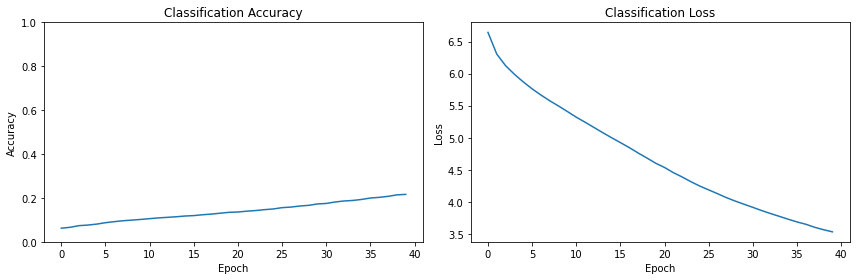

In [103]:
plot_history(history, (0,1))

## Batch Normalisation

In [97]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 50)            269250    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 200)           200800    
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 200)           800       
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               320800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_7 (Dense)              (None, 5385)             

In [104]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(training, ground_truth, batch_size=128, epochs=40) 

Epoch 1/40
351/351 [==============================] - 15s 43ms/step - loss: 6.6063 - accuracy: 0.0603
Epoch 2/40
351/351 [==============================] - 15s 42ms/step - loss: 6.0857 - accuracy: 0.0779
Epoch 3/40
351/351 [==============================] - 15s 42ms/step - loss: 5.6014 - accuracy: 0.1087
Epoch 4/40
351/351 [==============================] - 15s 42ms/step - loss: 5.1575 - accuracy: 0.1377
Epoch 5/40
351/351 [==============================] - 15s 42ms/step - loss: 4.7254 - accuracy: 0.1642
Epoch 6/40
351/351 [==============================] - 15s 42ms/step - loss: 4.2521

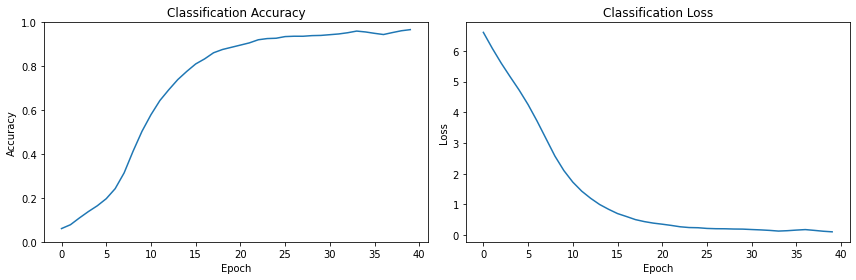

In [105]:
plot_history(history, (0,1))

#### The model has overfitted here and has simply remembered the text. This probably wont generalise well given some new data. 

Possibly overfitting here! Might be worth adding dropout now. 

## BatchNorm and Dropout

In [109]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            269250    
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 200)           200800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 200)               320800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)              

In [110]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(training, ground_truth, batch_size=128, epochs=40) 

Epoch 1/40
351/351 [==============================] - 15s 43ms/step - loss: 6.6160 - accuracy: 0.0606
Epoch 2/40
351/351 [==============================] - 15s 43ms/step - loss: 6.2034 - accuracy: 0.0690
Epoch 3/40
351/351 [==============================] - 15s 43ms/step - loss: 5.8626 - accuracy: 0.0865
Epoch 4/40
351/351 [==============================] - 15s 43ms/step - loss: 5.5048 - accuracy: 0.1099
Epoch 5/40
351/351 [==============================] - 15s 43ms/step - loss: 5.1434 - accuracy: 0.1311
Epoch 6/40
351/351 [==============================] - 15s 43ms/step - loss: 4.8008

In [22]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(data_train, ground_truth_train, batch_size=128, validation_data=(data_val, ground_truth_val),  epochs=40) 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            319100    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 200)           200800    
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 200)           800       
_________________________________________________________________
dropout (Dropout)            (None, 50, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0

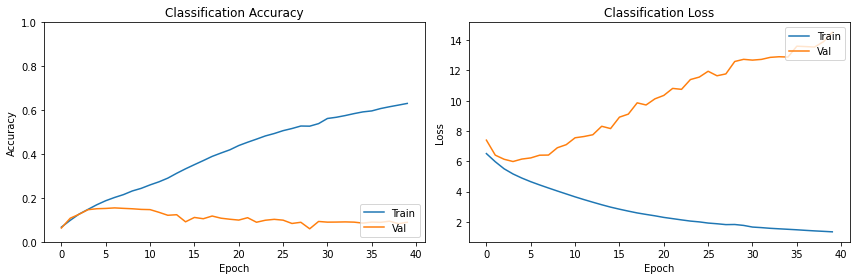

In [26]:
plot_history(history, (0,1))

The models are clearly overfitting, however the task at hand it to create words in the same *style* as Agatha Christie not recreate her works! 

In [29]:
os.mkdir('./PoirotSavedModels/TweetTokenizer')

In [30]:
# save the model to file
model.save('./PoirotSavedModels/TweetTokenizer/BatchNorm_Dropout.h5')
# save the tokenizer
dump(tokenizer, open('./PoirotSavedModels/TweetTokenizer/BatchNorm_Dropout.pkl', 'wb'))

## Adding width to the network with more neurons in the dense layer. 

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(800, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(800, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(data_train, ground_truth_train, batch_size=128, validation_data=(data_val, ground_truth_val),  epochs=60) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            319100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 200)           200800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 200)           800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)              

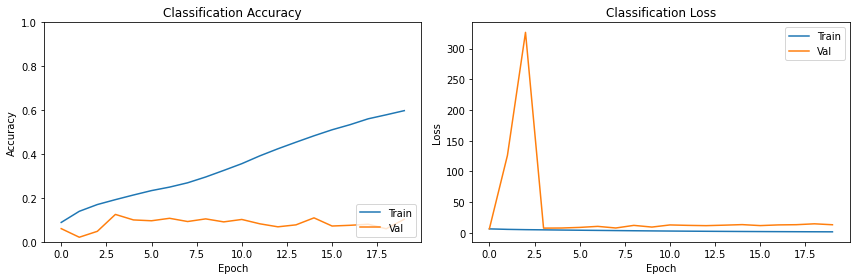

In [23]:
plot_history(history, (0,1))

Im not entirely sure what happened here. Perhaps the optimiser divereged on the loss surface and reset to the last minima it was in. 

##  Remove the width and train the network for 60 epochs dropout rate at 0.25

In [16]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(data_train, ground_truth_train, batch_size=128, validation_data=(data_val, ground_truth_val),  epochs=60) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            319100    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 200)           200800    
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 200)           800       
_________________________________________________________________
dropout (Dropout)            (None, 50, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0

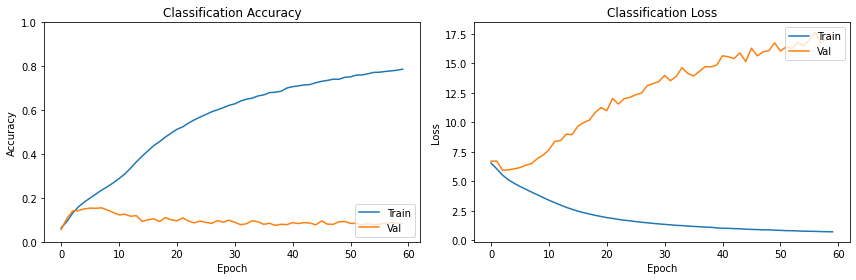

In [18]:
plot_history(history, (0,1))

In [19]:
# save the model to file
model.save('./PoirotSavedModels/TweetTokenizer/BatchNorm_Dropout_Model.h5')
# save the tokenizer
dump(tokenizer, open('./PoirotSavedModels/TweetTokenizer/FinalTokenizer.pkl', 'wb'))

___

## Generate predictions

In [34]:
from random import randint
from pickle import load
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# generate a sequence from a language model
def generate_seq(model, tokenizer, n_words, test_text=""):
	
	if len(test_text) >= 1 :
		test_text = test_text
	else :
		test_text = input('Type out a sentence and the model will complete it in the style of Agatha Chritie! (Hopefully)')

	print(test_text + '\n')
	
	result = list()
	in_text = test_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=50, truncating='pre')  ## We account for shorter input sentences by padding the embedding layer at the front of the sequence. We must have 50 words in the embedding to match the model architecture
		# predict probabilities for each word
		yhat = np.argmax(model.predict(encoded), axis=-1)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
		return ' '.join(result)
	


# load cleaned text sequences
in_filename = 'poirot_sequences_tweetTokenizer.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1
 
# load the model
model = load_model('./PoirotSavedModels/TweetTokenizer/BatchNorm_Dropout.h5')
 
# load the tokenizer
tokenizer = load(open('./PoirotSavedModels/TweetTokenizer/BatchNorm_Dropout.pkl', 'rb'))
 
# select a test text
test_text = lines[randint(0,len(lines))]

 
# generate new text
generated = generate_seq(model, tokenizer, 50, test_text)
print(generated)

he did it ? A man cannot be tried twice for murder , Hastings . Endeavour to have the common sense . Ah , that is our friends ring . A few minutes later Signor Ascanio was ushered in a small , thin man with a secretive and furtive glance in

the stone as I do . Just a formality . Oh , let them take it . Just a minute he said , mademoiselle . This is it is that I am not , Monsieur Poirot . I am afraid you answer that is as we know . I am


In [41]:
def generate_seq(model, tokenizer, n_words, test_text=""):
	
	if len(test_text) >= 1 :
		test_text = test_text
	else :
		test_text = input('Type out a sentence and the model will complete it in the style of Agatha Chritie! (Hopefully)')

	print(test_text + '\n')
	
	result = list()
	in_text = test_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=50, truncating='pre')
		# predict probabilities for each word
		yhat = np.argmax(model.predict(encoded), axis=-1)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

In [42]:
generated = generate_seq(model, tokenizer, 50)
print(generated)

After a hard day on the job Poirot returned home and opened himself a nice cold beer and then

by the following Lord Yardly , and tell me that he was clearly terrified to do with all Poirot in greeting so again And he merely asked . Tell me if I can do you think it is necessary so ? As he handed me to go curiously for Miss


In [31]:
Test[:1000]

'e. He seemed an intelligent fellow.\n\nWe returned to Crabtree Manor in high spirits, and, locking the\nstudy door, proceeded to put our newly acquired knowledge into\neffect. It was impossible to see any sign on the bricks, but when\nwe pressed in the manner indicated, a deep cavity was at once\ndisclosed.\n\nEagerly Poirot plunged in his hand. Suddenly his face fell from\ncomplacent elation to consternation. All he held was a charred\nfragment of stiff paper. But for it, the cavity was empty.\n\n“_Sacré!_” cried Poirot angrily. “Some one has been before us.”\n\nWe examined the scrap of paper anxiously. Clearly it was a fragment\nof what we sought. A portion of Baker’s signature remained, but no\nindication of what the terms of the will had been.\n\nPoirot sat back on his heels. His expression would have been\ncomical if we had not been so overcome.\n\n“I understand it not,” he growled. “Who destroyed this? And what\nwas their object?”\n\n“The Bakers?” I suggested.\n\n“_Pourquoi?_ Ne

In [20]:
from random import randint
from pickle import load
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# generate a sequence from a language model
def generate_seq(model, tokenizer, n_words, test_text=""):
	
	if len(test_text) >= 1 :
		test_text = test_text
	else :
		test_text = input('Type out a sentence and the model will complete it in the style of Agatha Chritie! (Hopefully)')

	print(test_text + '\n')
	
	result = list()
	in_text = test_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=50, truncating='pre')  ## We account for shorter input sentences by padding the embedding layer at the front of the sequence. We must have 50 words in the embedding to match the model architecture
		# predict probabilities for each word
		yhat = np.argmax(model.predict(encoded), axis=-1)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

In [21]:
# load cleaned text sequences
in_filename = 'poirot_sequences_tweetTokenizer.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1
 
# load the model
model = load_model('./PoirotSavedModels/TweetTokenizer/BatchNorm_Dropout_Model.h5')
 
# load the tokenizer
tokenizer = load(open('./PoirotSavedModels/TweetTokenizer/FinalTokenizer.pkl', 'rb'))

In [22]:
# select a test text
test_text = lines[randint(0,len(lines))]

 
# generate new text
generated = generate_seq(model, tokenizer, 50, test_text)
print(generated)

picture of misery , wilted by my side . The little man was not a good traveller . Our four days voyage from Marseilles had been one long agony to him . He had landed at Alexandria the wraith of his former self , even his usual neatness had deserted him

. We had arrived in Cairo and had driven out at once to the Mena House Hotel , right in the shadow of the Pyramids . The charm of Egypt had laid hold of me . Not so Poirot . Dressed precisely the same as in London , demanded the


In [27]:
print(Test[1000:2000])

ion for them, and they
are more likely to be kept on with Miss Marsh than if the place
became the property of a hospital. How could it be to anyone’s
advantage to destroy the will? The hospitals benefit—yes; but one
cannot suspect institutions.”

“Perhaps the old man changed his mind and destroyed it himself,”
I suggested.

Poirot rose to his feet, dusting his knees with his usual care.

“That may be,” he admitted. “One of your more sensible observations,
Hastings. Well, we can do no more here. We have done all that
mortal man can do. We have successfully pitted our wits against
the late Andrew Marsh’s; but, unfortunately, his niece is no better
off for our success.”

By driving to the station at once, we were just able to catch a
train to London, though not the principal express. Poirot was sad
and dissatisfied. For my part, I was tired and dozed in a corner.
Suddenly, as we were just moving out of Taunton, Poirot uttered a
piercing squeal.

“_Vite_, Hastings! Awake and jump! But jump

In [31]:
test_text = "That may be, he admitted. “One of your more sensible observations,Hastings. Well, we can do no more here. We have done all that mortal man can do. We have"

# generate new text
generated = generate_seq(model, tokenizer, 50, test_text)
print(generated)

That may be, he admitted. “One of your more sensible observations,Hastings. Well, we can do no more here. We have done all that mortal man can do. We have

four at the letters before Mr . Davenheim . One eye will be off one , a minor official connected with the British Museum Mr . Schneider of the Metropolitan Museum in New York a young American secretary Dr . Ames , sir . Shall I tell her ‘ John
